In [151]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean

%matplotlib inline
plt.style.use('ggplot')

In [152]:
def grab_data(start,end,ticker):

    data = web.DataReader(ticker, 'yahoo', start, end)
    data.reset_index(inplace=True)
    data.Date = data.Date.apply(lambda x: np.datetime64(x))
    data.set_index('Date',inplace=True)
    
    return data.copy()

In [153]:
# what is the correct way to normalize the data? 

# while doing analysis, need a way to ensure that we only pull data from which there exists enough historical data to
# fill the features (simple solution: if len(self.featurewindow) is not the correct amount, don't add to the database)


# pandas has functions .diff() and .pcnt_change() to calculate additive/multiplicative changes in time series

# alternatives to normalize(): define functions that transforms time series to differences ? (or % changes) 

In [154]:
# yahoo API sometimes returns an error.. must re-run the code -- thus the while-try-except block

# pull data from 1 year before the period to be analyzed -- we need to guarantee that we have historical data
# (assuming that there is stock data from 1999 onwards) 

# use returns from close prices of consecutive trading days

class stock:
    def __init__(self,start,end,ticker):
        self.start = start
        self.end = end
        self.ticker = ticker
        self.x = 0
        while(self.x<5):
            try:
                self.data = grab_data(np.datetime64(self.start)-np.timedelta64(370,'D'),self.end,self.ticker)
                break
            except:
                self.x+=1
                continue
            
    def grab_returns(self,window=1,featurelength=255):
        self.window=window
        self.featurelength = featurelength
        self.returns = (self.data.loc[self.data.index>=start][window:].reset_index().Close-\
                             self.data.loc[self.data.index>=start][:-window].reset_index().Close)/\
                             self.data.loc[self.data.index>=start][:-window].reset_index().Close
        self.returns.index = self.data.loc[self.data.index>=start][window:].index
        self.maxreturn = self.returns.max()
        self.maxend = np.datetime64(self.returns[self.returns==self.maxreturn].index[0])
        self.maxbegin = self.data[(self.data.index<=self.maxend)][-(self.window):-(self.window-1)].index[0]
        self.maxreturndata = self.data.loc[(self.data.index<=self.maxend)&(self.data.index>=(self.maxbegin))]
        self.maxoneyear = self.data[(self.data.index<=self.maxend) & (self.data.index>=(self.maxbegin-np.timedelta64(366,'D')))]
        self.featurewindow = self.data[self.data.index<self.maxbegin][-(featurelength+200):]
        self.featurewindow['MA200'] = self.featurewindow.Close.rolling(window=200).mean()
        self.featurewindow['MA100'] = self.featurewindow.Close.rolling(window=100).mean()
        self.featurewindow['MA50'] = self.featurewindow.Close.rolling(window=50).mean()
        self.featurewindow['MA20'] = self.featurewindow.Close.rolling(window=20).mean()
        self.featurewindow['MA10'] = self.featurewindow.Close.rolling(window=10).mean()
        self.featurewindow = self.featurewindow[-(featurelength+1):].drop(['Open','High','Low','Adj Close'],axis=1)
        self.featurewindow['index'] = list(range(len(self.featurewindow)))
        self.featurewindow.set_index('index',append=True,inplace=True)
        self.featurewindowP = self.data[(self.data.index>self.maxend)][:featurelength]
        
        
    def normalize(self,mode='avg'):
        if mode=='pct':
            self.featurewindow.loc[:,'Close'] = self.featurewindow.pct_change().loc[:,'Close']
            self.featurewindow.loc[:,'MA200'] = self.featurewindow.pct_change().loc[:,'MA200']
            self.featurewindow.loc[:,'MA100'] = self.featurewindow.pct_change().loc[:,'MA100']
            self.featurewindow.loc[:,'MA50'] = self.featurewindow.pct_change().loc[:,'MA50']
            self.featurewindow.loc[:,'MA20'] = self.featurewindow.pct_change().loc[:,'MA20']
            self.featurewindow.loc[:,'MA10'] = self.featurewindow.pct_change().loc[:,'MA10']
            self.featurewindow.dropna(inplace=True)
        
            #self.featurewindowP.loc[:,'Close'] = self.featurewindowP.pct_change().loc[:,'Close']
            #self.featurewindowP.dropna(inplace=True)
            
            #self.maxreturndata.loc[:,'Close'] = self.maxreturndata.pct_change().loc[:,'Close']
            #self.maxreturndata.dropna(inplace=True)
            
        if mode=='avg':
            for col in self.featurewindow.columns:
                if col == 'Volume':
                    continue
                self.featurewindow.loc[:,col] = (self.featurewindow[col]-self.featurewindow[col].mean())/self.featurewindow[col].std()
        
            for col in self.featurewindowP.columns:
                self.featurewindowP.loc[:,col] = (self.featurewindowP[col]-self.featurewindowP[col].mean())/self.featurewindowP[col].std()
            
            for col in self.maxreturndata.columns:
                self.maxreturndata.loc[:,col] = (self.maxreturndata[col]-self.maxreturndata[col].mean())/self.maxreturndata[col].std()
            
    def engineer_features(self,mode='basic',count=2):
        self.features = []
        
        if mode == 'basic':
            for col in self.featurewindow.columns:
                self.features += list(self.featurewindow[col])
                
        if mode == 'discrete':
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            self.featuretemp = self.featurewindow.iloc[points].copy()
            for col in self.featuretemp.columns:
                self.features += list(self.featuretemp[col])
            del self.featuretemp
            
        if mode == 'interval': # only takes the avg closing prices (should normalize first) and volume over the intervals
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Close.mean()]
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Volume.mean()]
                
        if mode == 'interval_g': # take the geometric mean of daily returns over each interval. need to normalize to %s first
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                if k == (count - 2):
                        self.features += [gmean(self.featurewindow.iloc[points[k]:(points[k+1]+1)].Close+1)-1]
                        continue
                self.features += [gmean(self.featurewindow.iloc[points[k]:points[k+1]].Close+1)-1]

In [155]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2017, 12, 31)
ticker = 'SPY'

s = stock(start,end,ticker)
s.grab_returns(window=25)

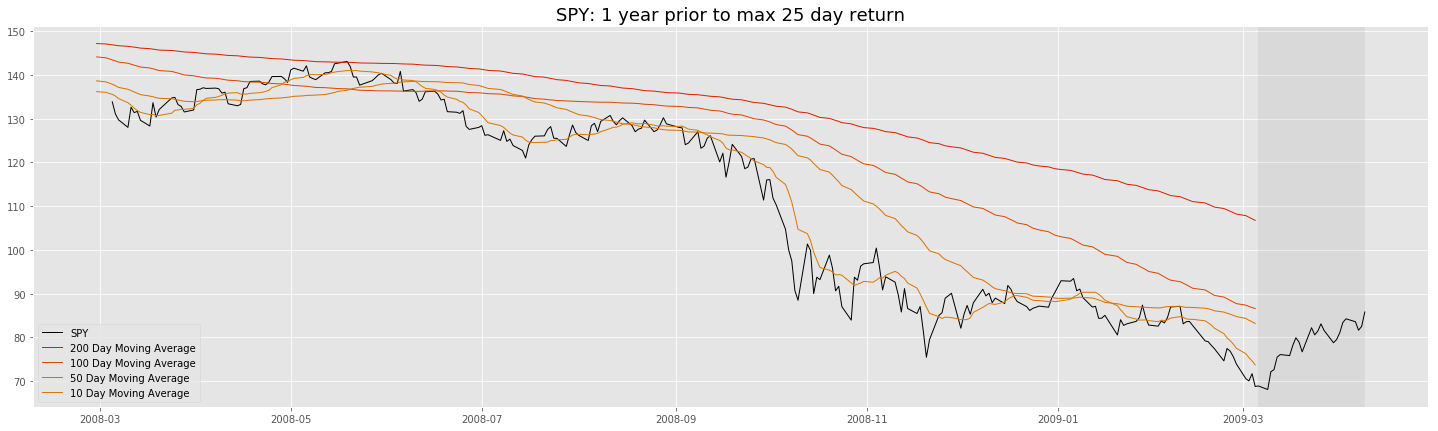

In [156]:
# timeline before the window of return, which is used to engineer features

fig, ((ax1)) = plt.subplots(1,1,figsize=(25,7))

ax1.plot(s.maxoneyear.index.get_level_values(0),s.maxoneyear.Close,'k',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA200,'#db2000',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA100,'#db4800',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA50,'#db7100',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA10,'#db7800',linewidth=1)
ax1.axvspan(s.maxbegin,s.maxend,facecolor='k',alpha=0.05)
ax1.set_title(ticker+': 1 year prior to max '+str(s.window)+' day return',fontsize=18)
ax1.legend([ticker,'200 Day Moving Average','100 Day Moving Average','50 Day Moving Average','10 Day Moving Average'])

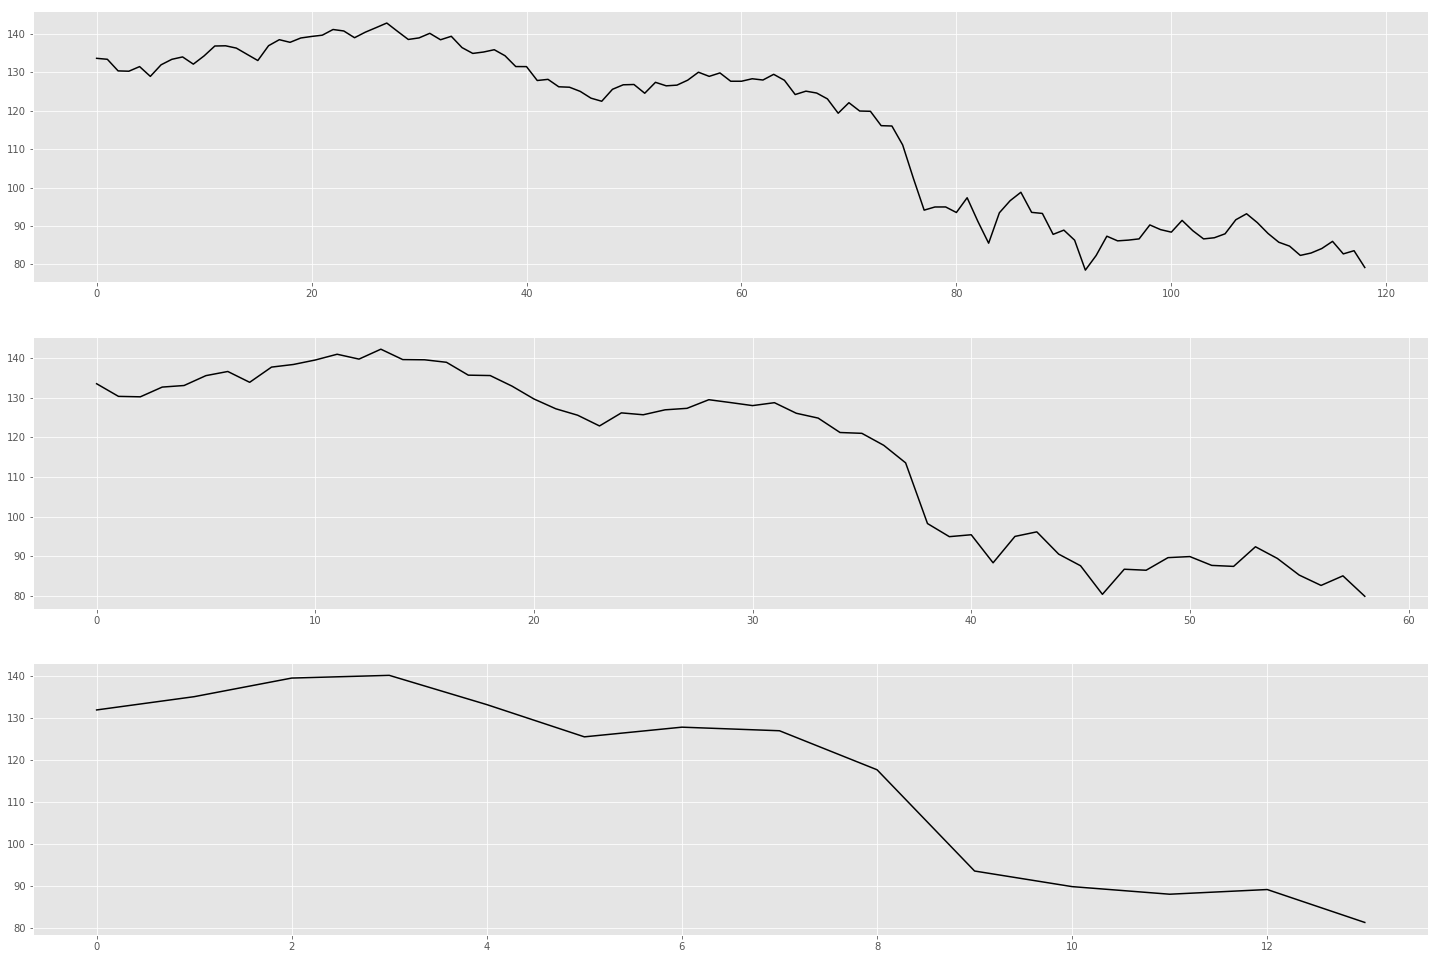

In [160]:
# clustering treats each point in the time series as an independent dimension -- this can only find very specific clusters
# thus, we want to 'smooth out' the time series to find more general price behavior over the timeline

# as the count of 'smoothing intervals' decreases, we get a more "general" characterization of the feature window.
# using price averages will not enable us to cluster, however... we need to normalize the prices

fig = plt.figure(figsize=(25,17))

for i,count in enumerate([120,60,15]):
    s.engineer_features(mode='interval',count=count)
    ax = fig.add_subplot(3,1,i+1)
    ax.plot(list(range(count-1)),s.features[:count-1],'k')


In [161]:
# should not include moving averages if we use pct changes

s.normalize(mode='pct')

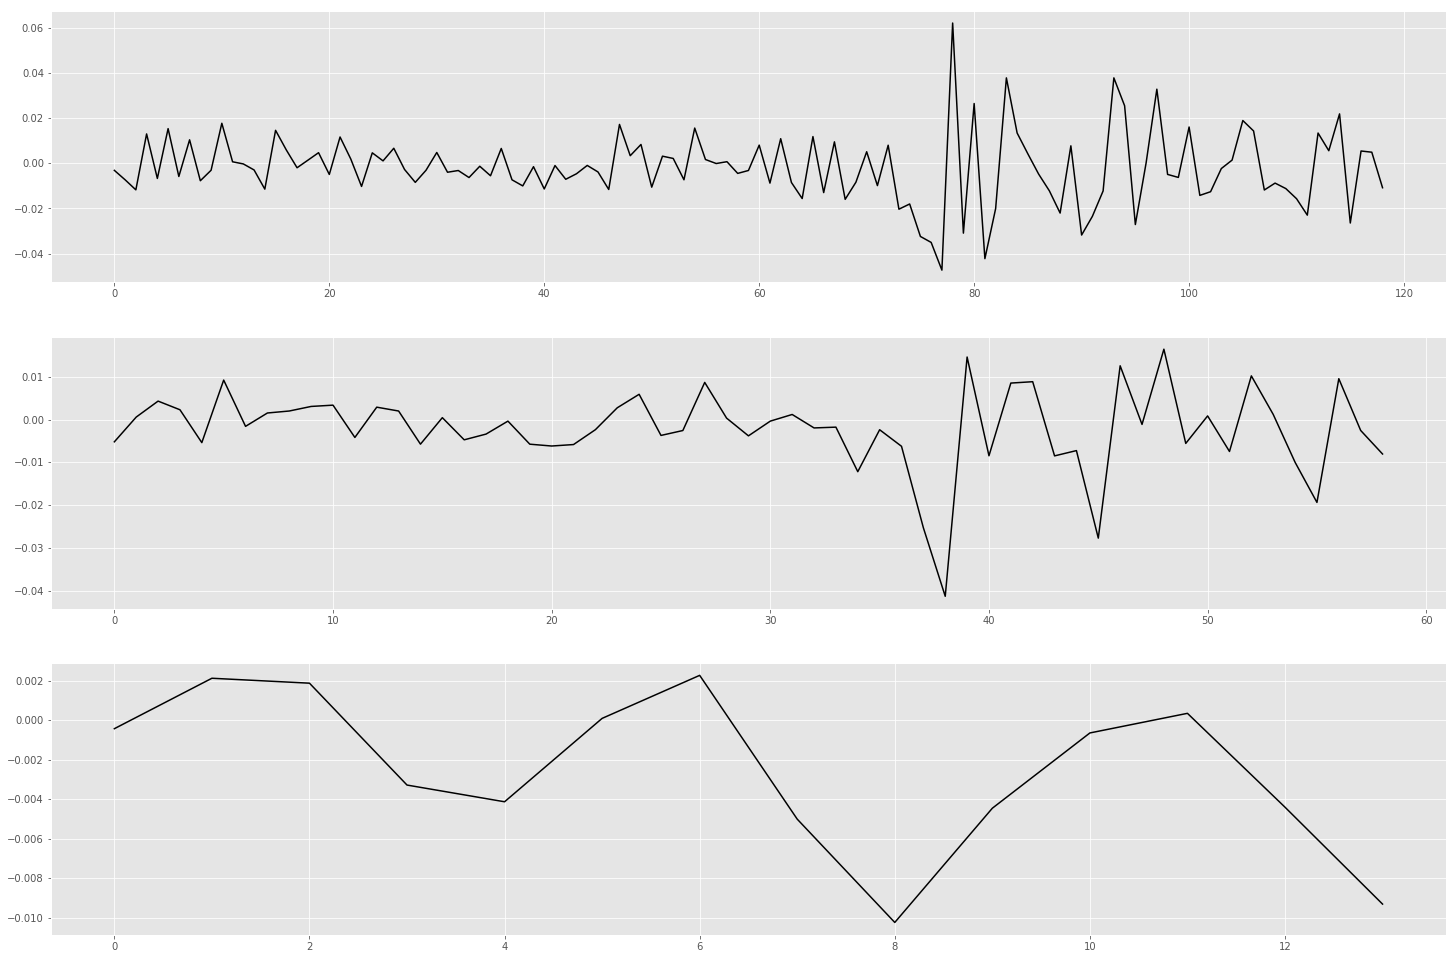

In [162]:
# instead of the average price of each interval, we can plot the geometric mean of the daily returns for each interval --
# this is one approach to normalizing the price behavior of different stocks

# too many intervals leads to over-specification of the price behavior. to find good clusters which generalize, we need to
# use a smaller count of intervals. 

fig = plt.figure(figsize=(25,17))

for i,count in enumerate([120,60,15]):
    s.engineer_features(mode='interval_g',count=count)
    ax = fig.add_subplot(3,1,i+1)
    ax.plot(list(range(count-1)),s.features[:count-1],'k')

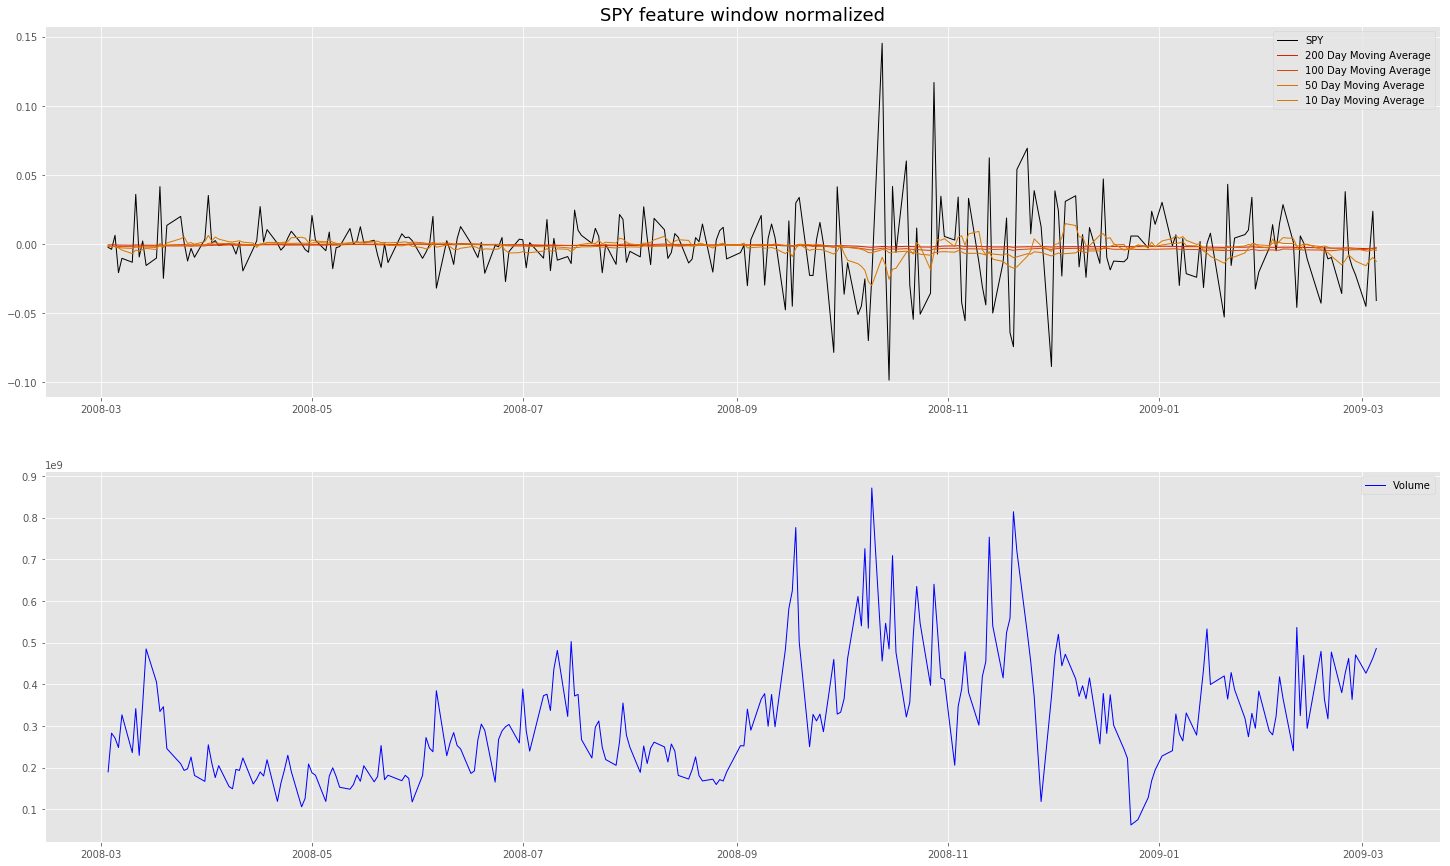

In [163]:
# since each day is treated as its own dimension, using the returns of every day to cluster will only find very specific
# groupings (more likely, no good groupings at all..) thus the approach above (geometric means over intervals) with 
# a suitable number of intervals will enable clustering algorithms to find better ('general') groupings

# these are the daily returns: r 
# remove moving averages? 

# normalize volume? may not be necessary

fig, ((ax1,ax2)) = plt.subplots(2,1,figsize=(25,15))

ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.Close,'k',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA200,'#db2000',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA100,'#db4800',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA50,'#db7100',linewidth=1)
ax1.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.MA10,'#db7800',linewidth=1)
ax1.set_title(ticker+' feature window normalized',fontsize=18)
ax1.legend([ticker,'200 Day Moving Average','100 Day Moving Average','50 Day Moving Average','10 Day Moving Average'])

ax2.plot(s.featurewindow.index.get_level_values(0),s.featurewindow.Volume,'b',linewidth=1)
ax2.legend(['Volume'])

print('')

In [164]:
mini_test = ['TSLA','SBUX','AMD','TWC','T','EA','EBAY','MSFT','ORCL','GE','YHOO','CSCO','F','L','THC','TMK',
            'MCD','ABT','TSCO','TRIP','FOXA','UA','URBN','EFX','AMZN','ALLE','TSN','MDLZ','ESV','EOG']

In [165]:
# cluster to look for similar price behavior from the mini-set, with 4 intervals (5 evenly spaced points)

k = 5

stock_df = pd.DataFrame(columns=list(range(k-1)))

for tick in mini_test:
    try:
        stk = stock(start,end,tick)
        stk.grab_returns(window=25)
        stk.normalize(mode='pct')
        stk.engineer_features(mode='interval_g',count=k)
        temp = [tick]+stk.features
        stock_df = stock_df.append(pd.DataFrame(temp).transpose())
        del stk
    except:
        continue
        
stock_df.columns=(['ticker']+list(range(len(stock_df.columns)-1)))
stock_df = stock_df.set_index('ticker')

In [166]:
stock_df.head()

,0,1,2,3
ticker,,,,
TSLA,0.000308907,-0.0030132,0.00285879,0.00596317
SBUX,-0.000916387,-0.00707887,0.0035415,0.00148942
AMD,-0.00404492,0.0078921,0.000218363,0.00346954
T,-0.0029672,-0.000599652,-0.00386462,-0.00579632
EA,0.01054,-0.00684363,-0.00178815,-0.00828019


In [167]:
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=10,random_state=2).fit(stock_df.values)
stock_df['Cluster'] = KM.labels_

In [168]:
# analyze the cluster with many members (clusters with too few members, e.g. 1, do not have similar characteristics with
# other data points)

len(stock_df[stock_df['Cluster']==1])

5

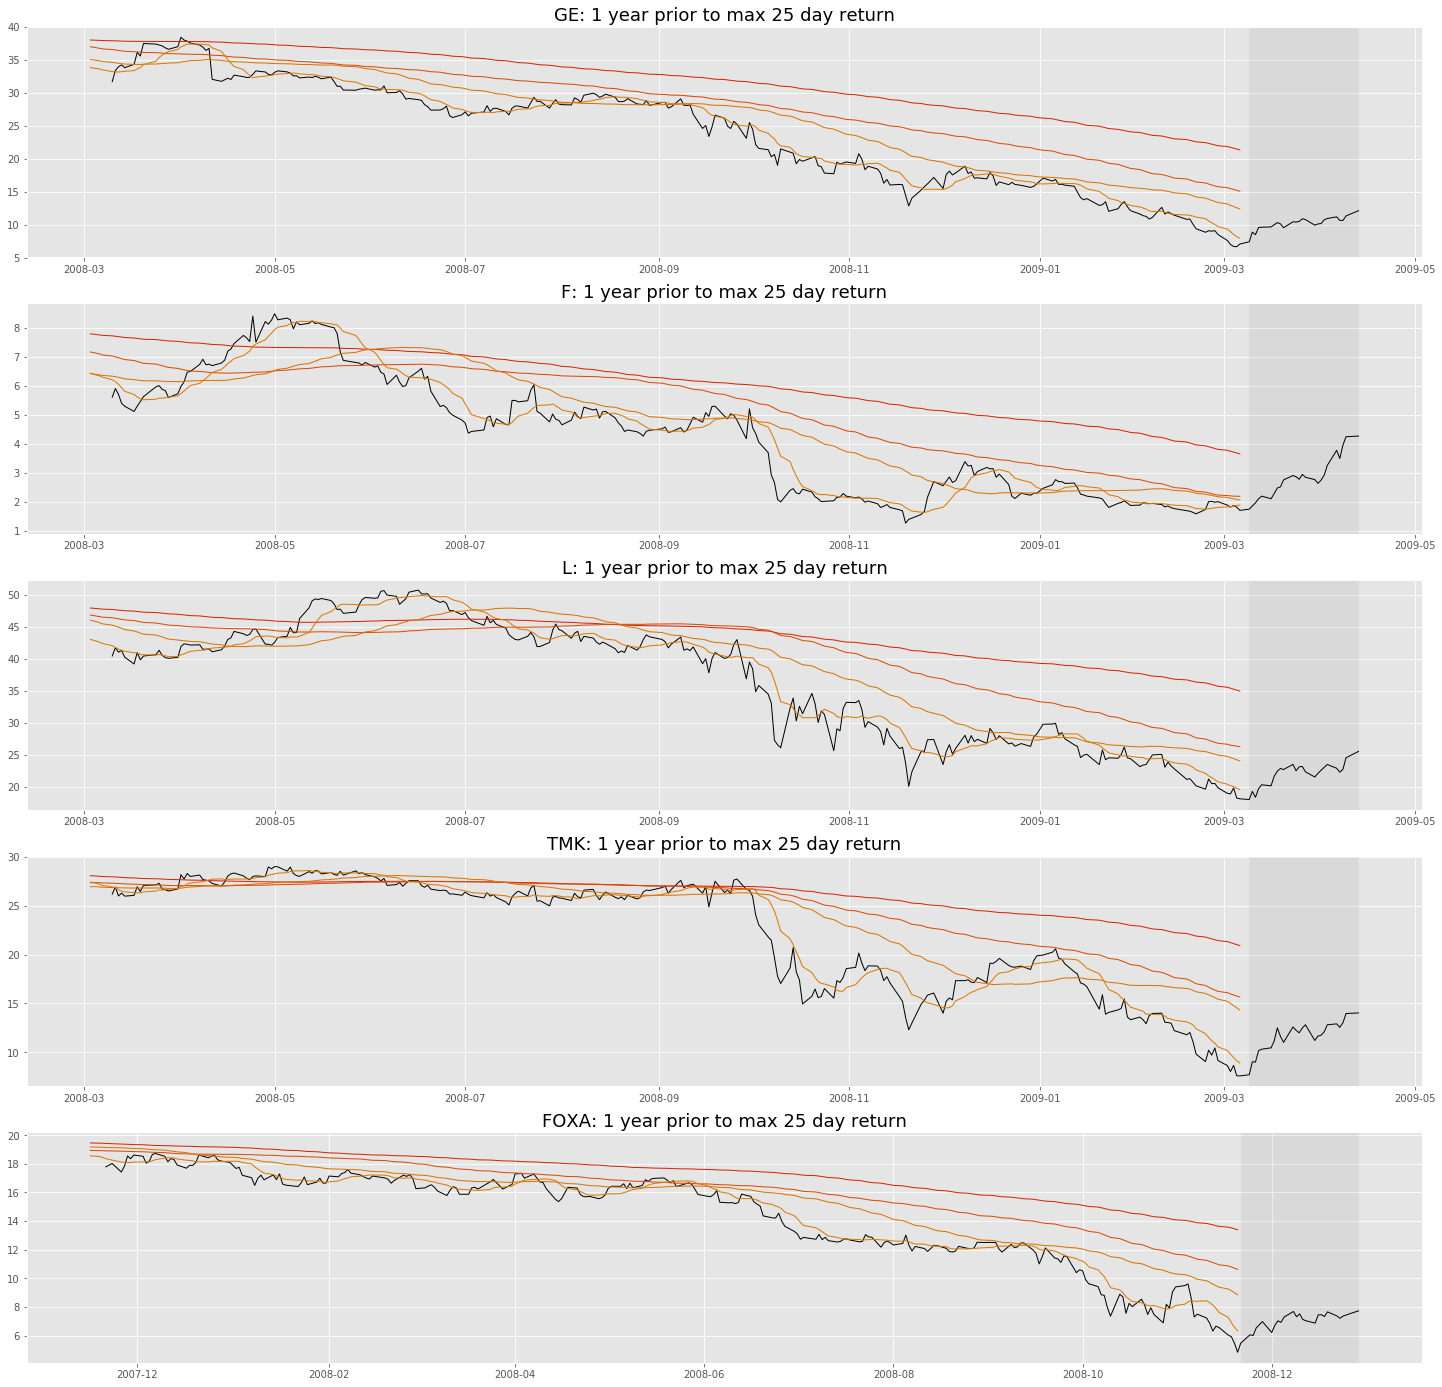

In [169]:
# KMeans can find long term ("general") structure to find similarities in geometric returns, but it seems this method
# is ineffective if the number of intervals is too large. below we have the case of 4 intervals

# there is a general dip in price in the half immediately preceding the 'best return' window in all the cases below, preceded
# by a general period of stability


# perhaps a bigger selection of stocks would find better clusters

fig = plt.figure(figsize=(25,50))

for i,tck in enumerate(stock_df[stock_df['Cluster']==1].index):
    
    b = stock(start,end,tck)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(10,1,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck+': 1 year prior to max '+str(b.window)+' day return',fontsize=18)
    #ax1.legend([tck,'200 Day Moving Average','100 Day Moving Average','50 Day Moving Average','10 Day Moving Average'])

In [170]:
# alternative clustering approach: cluster according to geometric means of different interval counts, then convert
# cluster labels to dummy variables and cluster again on the labels to find the final clusters (which will end up being
# determined as those which share many of the intermediate cluster labels)

k1 = 2
k2 = 3
k3 = 5

stock_df1 = pd.DataFrame(columns=list(range(k1-1)))
stock_df2 = pd.DataFrame(columns=list(range(k2-1)))
stock_df3 = pd.DataFrame(columns=list(range(k3-1)))

for tick in mini_test:
    try:
        stk = stock(start,end,tick)
        stk.grab_returns(window=25)
        stk.normalize(mode='pct')
        
        stk.engineer_features(mode='interval_g',count=k1)
        temp1 = [tick]+stk.features
        stock_df1 = stock_df1.append(pd.DataFrame(temp1).transpose())
        
        stk.engineer_features(mode='interval_g',count=k2)
        temp2 = [tick]+stk.features
        stock_df2 = stock_df2.append(pd.DataFrame(temp2).transpose())
        
        stk.engineer_features(mode='interval_g',count=k3)
        temp3 = [tick]+stk.features
        stock_df3 = stock_df3.append(pd.DataFrame(temp3).transpose())
        del stk
    except:
        continue
        
stock_df1.columns=(['ticker']+list(range(len(stock_df1.columns)-1)))
stock_df1 = stock_df1.set_index('ticker')

stock_df2.columns=(['ticker']+list(range(len(stock_df2.columns)-1)))
stock_df2 = stock_df2.set_index('ticker')

stock_df3.columns=(['ticker']+list(range(len(stock_df3.columns)-1)))
stock_df3 = stock_df3.set_index('ticker')

In [171]:
# geometric mean over 1 period of the feature window

stock_df1.head()

,0
ticker,
TSLA,0.00157609
SBUX,-0.000722737
AMD,0.00189297
T,-0.003338
EA,-0.0017497


In [172]:
# geometric means over 2 periods over the feature window

stock_df2.head()

,0,1
ticker,,
TSLA,-0.00153398,0.00467144
SBUX,-0.00366202,0.00220215
AMD,0.00233695,0.00145266
T,-0.00181406,-0.00484774
EA,0.00189589,-0.00533554


In [173]:
# geometric means over 4 periods over the feature window

stock_df3.head()

,0,1,2,3
ticker,,,,
TSLA,0.000308907,-0.0030132,0.00285879,0.00596317
SBUX,-0.000916387,-0.00707887,0.0035415,0.00148942
AMD,-0.00404492,0.0078921,0.000218363,0.00346954
T,-0.0029672,-0.000599652,-0.00386462,-0.00579632
EA,0.01054,-0.00684363,-0.00178815,-0.00828019


In [174]:
KM1 = KMeans(n_clusters=3,random_state=2).fit(stock_df1.values)
KM2 = KMeans(n_clusters=10,random_state=2).fit(stock_df2.values)
KM3 = KMeans(n_clusters=10,random_state=2).fit(stock_df3.values)

In [182]:
intermediate_labels = pd.DataFrame()

intermediate_labels['one'] = KM1.labels_
intermediate_labels['two'] = KM2.labels_
intermediate_labels['four'] = KM3.labels_

In [216]:
merge_list = [pd.get_dummies(intermediate_labels.one),
              pd.get_dummies(intermediate_labels.two),
              pd.get_dummies(intermediate_labels.four)]

In [218]:
dummies = pd.concat(merge_list,axis=1)
dummies.columns = list(range(23))

In [221]:
dummies.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [223]:
KM_FINAL = KMeans(n_clusters=10,random_state=2).fit(dummies.values)

In [247]:
stock_df1['FINAL_LABELS'] = KM_FINAL.labels_

In [265]:
len(stock_df1[stock_df1['FINAL_LABELS']==6])

5

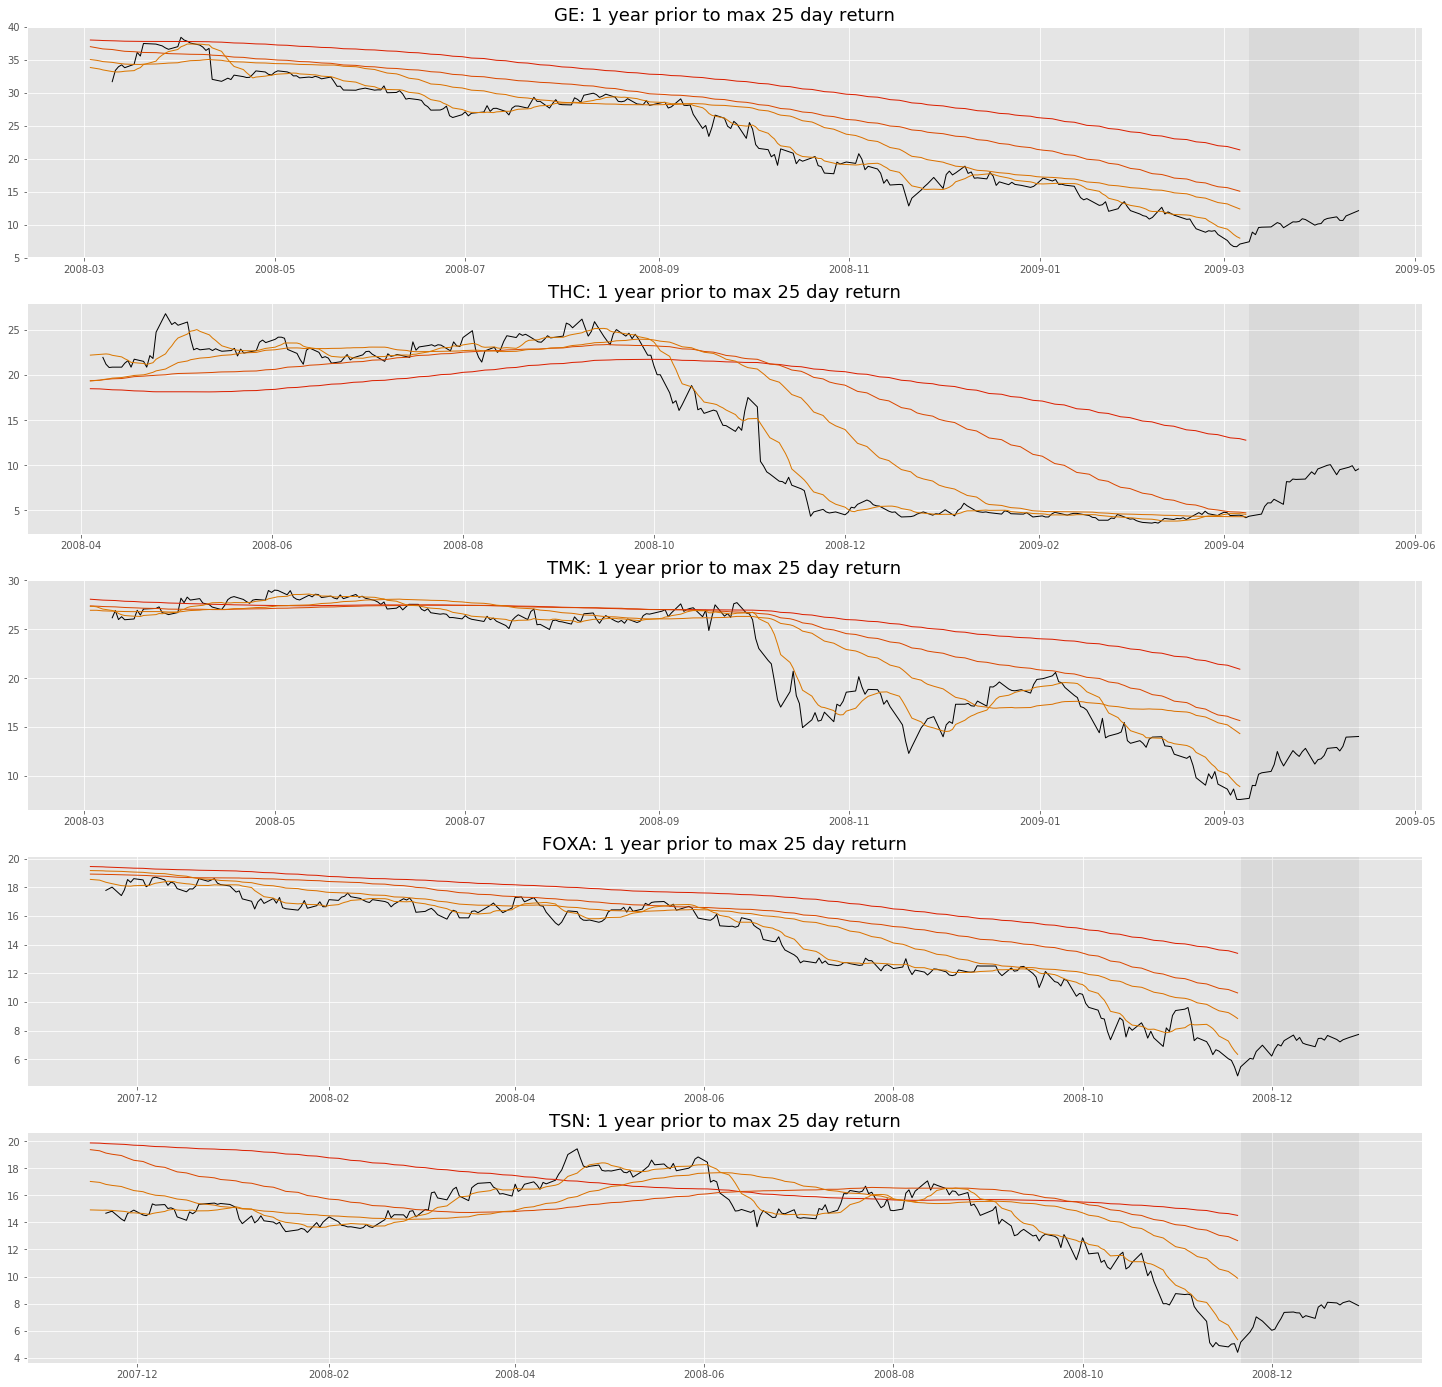

In [264]:
# with this "ensemble clustering" approach, the results are a bit less interpretable. they may not necessarily have
# similar price behavior throughout the period, but they were placed in a 'significant' number of the same clusters
# when we cluster by 1, 2, and 4 periods over the window

# aside -- the timelines below are all during the '07 - '09 crisis

fig = plt.figure(figsize=(25,50))

for i,tck in enumerate(stock_df1[stock_df1['FINAL_LABELS']==6].index):
    
    b = stock(start,end,tck)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(10,1,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck+': 1 year prior to max '+str(b.window)+' day return',fontsize=18)

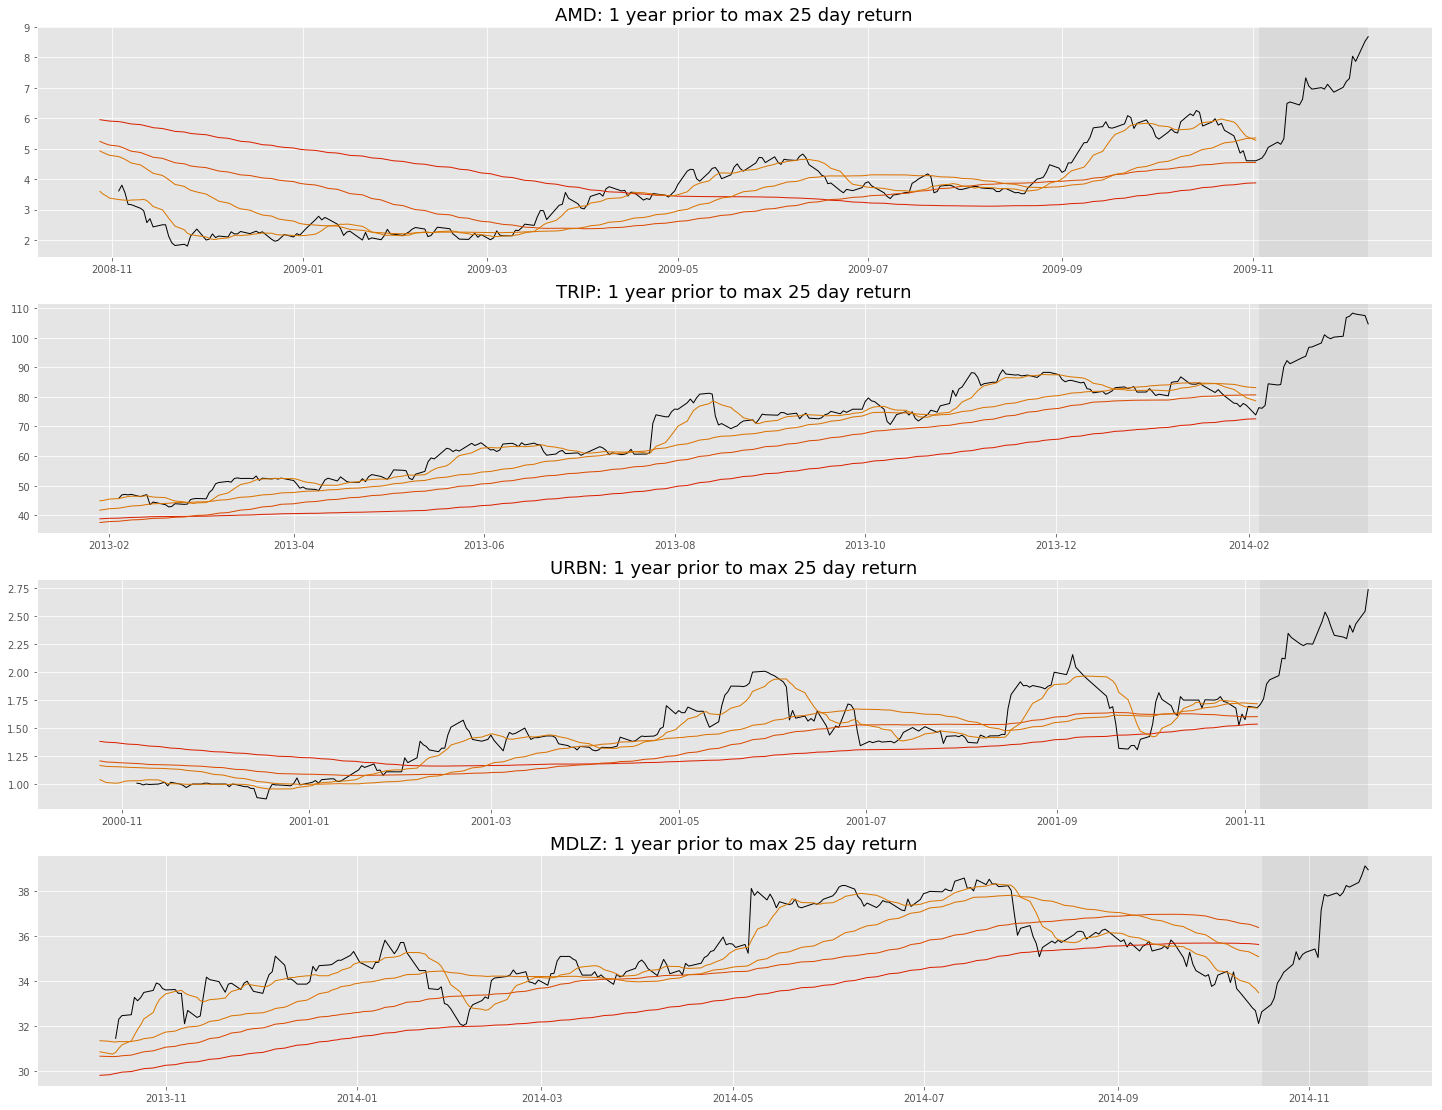

In [266]:
# cluster with the second most count -- the technique seems to find pretty good similarities in price behavior

fig = plt.figure(figsize=(25,50))

for i,tck in enumerate(stock_df1[stock_df1['FINAL_LABELS']==2].index):
    
    b = stock(start,end,tck)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(10,1,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck+': 1 year prior to max '+str(b.window)+' day return',fontsize=18)

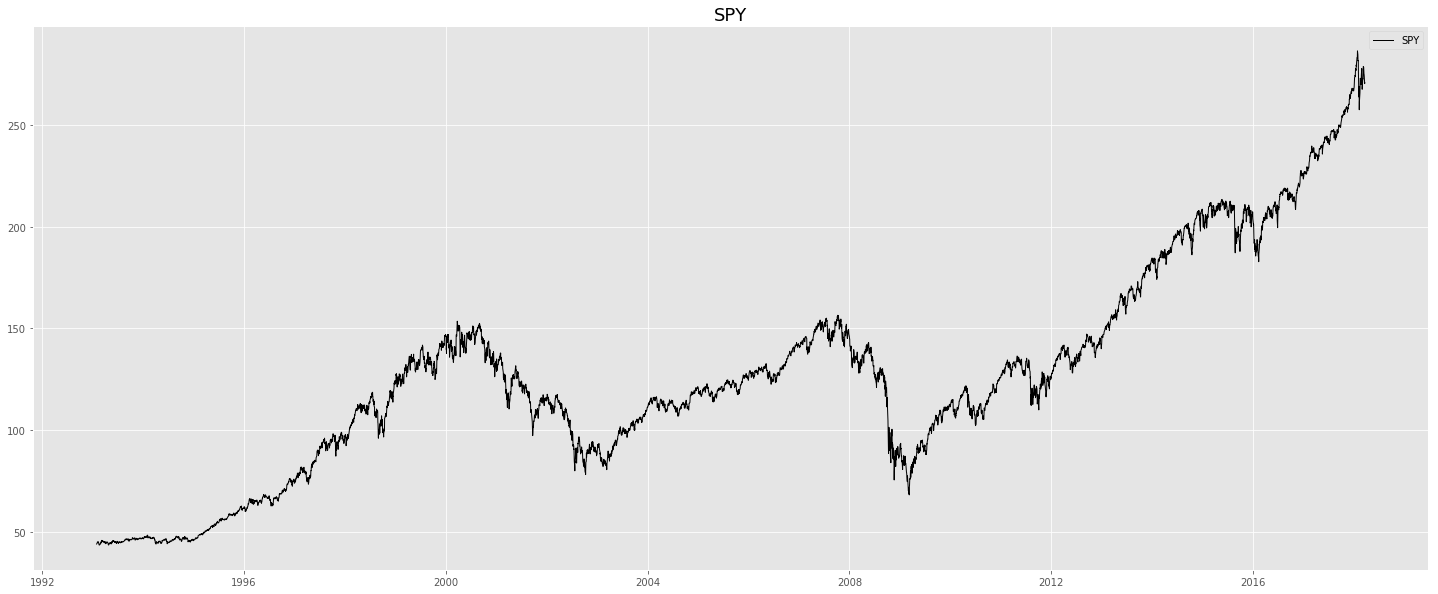

In [175]:
# ignore

start1 = datetime.datetime(1980, 1, 1)
end1 = datetime.datetime(2018, 12, 31)

ticker1 = 'SPY'

a = stock(start1,end1,ticker1)
a.grab_returns(window=25)

fig, ax1 = plt.subplots(1,1,figsize=(25,10))

ax1.plot(a.data.index,a.data.Close,linewidth=1,color='k')
ax1.set_title(ticker1,fontsize=18)
ax1.legend([ticker1])


print('')

In [176]:
#with open(os.getcwd()+'\\ticker-symbols.txt','r') as f:
#    ticker = f.read()

In [177]:
#ticker = ticker.split(', ')
#tickers = []

#for t in ticker:
#    tickers.append(t.strip('\''))
   
#tickers.remove("KIM'. 'KMI")
#tickers.append('KIM')
#tickers.append('KMI')
#tickers.sort()

In [178]:
# write the data?


#data_dict = {}

#for t in tickers:
#    try:
#        f = web.DataReader(t, 'yahoo', start, end)
#        data_dict[t] = f
#    except:
#        continue
        